In [1]:
%load_ext autoreload
%autoreload 2

# Homogeneous Medium Initial Value Problem

*This example notebook follows the [Homogeneous Propagation Medium Example](http://www.k-wave.org/documentation/example_ivp_homogeneous_medium.php) of [k-Wave](http://www.k-wave.org/).*

## Setup
### Domain

Similarly to k-Wave, j-Wave requires the user to specify a computational domain where the simulation takes place. This is done using the `Domain` dataclass which is lifted from [`jaxdf`](https://github.com/ucl-bug/jaxdf).

The inputs for the constructor are the size of the domain in grid points in each spatial direction, and the corresponding discretization steps.

In [2]:
from jwave.geometry import Domain

N, dx = (128, 128), (0.1e-3, 0.1e-3)
domain = Domain(N, dx)

### Acoustic medium

In this example, the speed of sound has a constant value of $1500m/s$. The speed of sound is defined as part of the `Medium` dataclass, which also needs the computational domain as mandatory input argument

In [3]:
from jwave.geometry import Medium

medium = Medium(domain=domain, sound_speed=1500.)
print(medium)

Medium:
 - attenuation: 0.0
 - density: 1.0
 - domain: Domain(N=(128, 128), dx=(0.0001, 0.0001))
 - pml_size: 20
 - sound_speed: 1500.0


### Time

Time-stepping simulations requires to define a `TimeAxis` object, which is used by the timestepping scheme of the numerical simulation. To ensure a stable simulation, this object can be constructed from the `medium` object for a given [CFL number](https://it.wikipedia.org/wiki/Condizione_di_Courant-Friedrichs-Lewy).

In [4]:
from jwave.geometry import TimeAxis

time_axis = TimeAxis.from_medium(medium, cfl=0.3)

### Initial pressure

The initial pressure distribution is a Field, therefore it must be somehow represented according to a discretization. Most of the functions of `jwave` are tested using a `FourierSeries` discretization: since in this example we are not interested in tweaking the underlying discretization, we will use this class to define the initial pressure field.

In [23]:
from jwave.geometry import _circ_mask
from jwave import FourierSeries
from jax import numpy as jnp

p0 = 1.0*jnp.expand_dims(_circ_mask(N, 4, (80,60)), -1)
p0 = FourierSeries(p0, domain)

Text(0.5, 1.0, 'Initial pressure field')

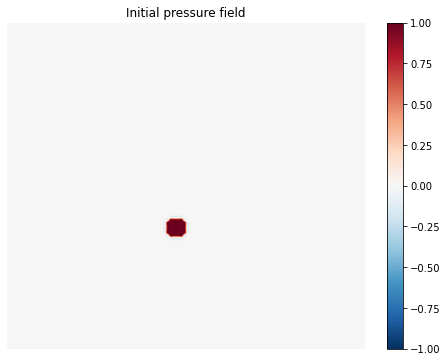

In [24]:
from matplotlib import pyplot as plt
from jwave.utils import show_field

show_field(p0)
plt.title(f"Initial pressure field")

## Run the simulation

In [25]:
from jwave.acoustics import simulate_wave_propagation
from jax import jit

@jit
def compiled_simulator(medium, p0):
    return simulate_wave_propagation(medium, time_axis, p0=p0)

In [26]:
pressure = compiled_simulator(medium, p0)['p']

Text(0.5, 1.0, 'Pressure field at t=4.0199997783929575e-06')

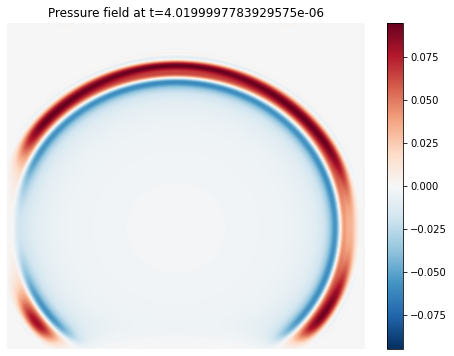

In [27]:
show_field(pressure[201])
plt.title(f"Pressure field at t={time_axis.to_array()[201]}")

## Timings

In [29]:
%timeit compiled_simulator(medium, p0)['p'].params.block_until_ready()

38.8 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
